In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

## Feature Building

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)

     # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)   

## Create training and test sets

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=42)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Training Data

## Model: SVM Linear

In [5]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.001, l1_ratio=0.5, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 11381, 'TN': 113913, 'FP': 762, 'FN': 1600, 'Accuracy': 0.9814971485868271, 'Precision': 0.9372477970847402, 'Recall': 0.8767429319775056, 'desc': 'svm_train'}


## Model: Ridge Regression

In [26]:
from sklearn import linear_model


rdg = linear_model.RidgeClassifier(alpha=1, normalize=True, tol=0.0001, solver='sag')
rdg.fit(X_train, y_train)
rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)


{'Pos': 12981, 'Neg': 114675, 'TP': 12946, 'TN': 100448, 'FP': 14227, 'FN': 35, 'Accuracy': 0.8882778717804098, 'Precision': 0.47642880800794907, 'Recall': 0.9973037516370079, 'desc': 'rdg_train'}


## Model: Ensemble

In [27]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('svm', svm), ('rdg', rdg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
ensemble_performance_train = BinaryClassificationPerformance(ensemble.predict(X_train), y_train, 'ensemble_train')
ensemble_performance_train.compute_measures()
print(ensemble_performance_train.performance_measures)

{'Pos': 12981, 'Neg': 114675, 'TP': 11344, 'TN': 113983, 'FP': 692, 'FN': 1637, 'Accuracy': 0.9817556558250298, 'Precision': 0.9425058158856763, 'Recall': 0.8738926122794854, 'desc': 'ensemble_train'}


### Looking at some false positives

In [28]:
ensemble_predictions = ensemble.predict(X_train)

# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ensemble_predictions)):
    if (ensemble_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
2265
Gallery
I've removed a picture from the gallery of a woman using a squat toilet. I didn't see what was encyclopedic about a woman hamming for the camera with her pants and underpants around her knees.
* * * * * * * * * 
4208
"
To Sandstein, No you are absolutely wrong talk pages are deleted here is Wikimedia's stance on the matter  User and talk pages, and their subpages, and other non-article pages that no others have substantively contributed to and whose existence does not impact the project, may be courtesy blanked or deleted.. When you are an administrator you have responsibilities that includes upholding Wikimedia's legal policy's. I have asked for 'ALL' of my user space to be deleted and that includes my talk page. I WILL be taking legal action personally against you if not fulfilled and believe me this is not a threat it is an absolute promise, look you don't know me one bit my Dad bought me a house when I was 21 I now have three cars and a boa

99650
Fool 

So what it doesn't need to go there because i don't want administrators knowing that needs to be deleted.
* * * * * * * * * 
101036
One question to the admins: If you intend to let the greek nazi propaganda pusher editors shape the article with NO evidence, isn't it better to use a forum to read this greek nazi crap instead of Greekopedia, at leat there they dont have to pretend to be objective.
* * * * * * * * * 
101333
dispute 

First i am restoring the censored information this user chose to remove from his page as it is relevent to this post

censored-information
Please be aware i made 1 edit and 2 reverts please learn to count, it takes 3 reverts to break 3rr now please fuck off and go back to your nazi policy enforcement and supporting of slave labor

you cunt94.168.204.89 (talk) 
censored-information-

As to your comment on my talk page i once again state i have only made two reverts not three so once again learn to count
secondly if you would like users to be civil

### ROC plot for training data

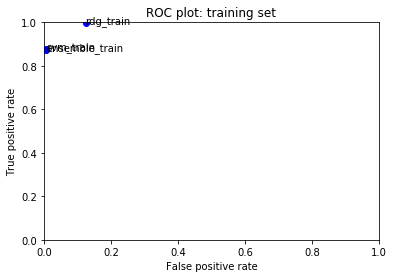

In [30]:
fits = [svm_performance_train, rdg_performance_train, ensemble_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Test Data

In [31]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2316, 'TN': 28072, 'FP': 599, 'FN': 928, 'Accuracy': 0.952154159486135, 'Precision': 0.7945111492281304, 'Recall': 0.7139334155363748, 'desc': 'svm_test'}


In [32]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 3110, 'TN': 22706, 'FP': 5965, 'FN': 134, 'Accuracy': 0.8088986370045433, 'Precision': 0.3426997245179063, 'Recall': 0.9586929716399507, 'desc': 'rdg_test'}


In [33]:
ensemble_performance_test = BinaryClassificationPerformance(ensemble.predict(X_test), y_test, 'ensemble_test')
ensemble_performance_test.compute_measures()
print(ensemble_performance_test.performance_measures)

{'Pos': 3244, 'Neg': 28671, 'TP': 2341, 'TN': 28103, 'FP': 568, 'FN': 903, 'Accuracy': 0.9539088203039323, 'Precision': 0.8047438982468202, 'Recall': 0.7216399506781751, 'desc': 'ensemble_test'}


In [34]:
# read in test data for submission
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=42, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

In [38]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ensemble.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.22261758637800005


In [36]:
### ROC plot for test data

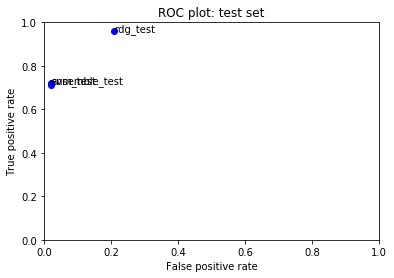

In [37]:
fits = [svm_performance_test, rdg_performance_test, ensemble_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [39]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [40]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [41]:
my_submission.shape

(153164, 2)

In [42]:
# export submission file as csv
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission_final.csv', index=False)